# Book Clustering Statistics

This notebook provides statistics on the results of our book clustering.

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from bookdata.db import db_url

## Load Data

Let's start by getting our clusters and their statistics:

In [3]:
clusters = pd.read_sql_table('cluster_stats', db_url())
clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11711006 entries, 0 to 11711005
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   cluster      int64  
 1   isbns        int64  
 2   loc_recs     float64
 3   ol_editions  float64
 4   ol_works     float64
 5   gr_books     float64
 6   gr_works     float64
dtypes: float64(5), int64(2)
memory usage: 625.4 MB


In [4]:
clusters.set_index('cluster', inplace=True)

Describe the count columns for basic descriptive stats:

In [5]:
clusters.describe()

,isbns,loc_recs,ol_editions,ol_works,gr_books,gr_works
count,1.171101e+07,5.267327e+06,1.046579e+07,1.046579e+07,1.096636e+06,1.096636e+06
mean,1.962229e+00,1.067427e+00,1.366533e+00,9.462325e-01,1.495023e+00,1.011412e+00
std,5.428214e+00,6.441693e-01,2.960089e+00,9.833372e-01,3.977768e+00,2.816754e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
50%,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
75%,2.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
max,7.818000e+03,6.100000e+02,3.760000e+03,2.368000e+03,2.266000e+03,8.500000e+01


75% of clusters only contain 2 ISBNs (probably -10 and -13) and one book. OpenLibrary also contributes to the largest number of clusters.

## Distributions

Let's look at the distributions of cluster sizes.

In [6]:
size_dist = pd.concat(dict(
    (c, clusters[c].value_counts()) for c in clusters.columns
), names=['RecType'])
size_dist.index.set_names(['RecType', 'RecCount'], inplace=True)
size_dist = size_dist.reset_index(name='Clusters')
size_dist.head()

,RecType,RecCount,Clusters
0,isbns,2.0,6287903
1,isbns,1.0,4302444
2,isbns,4.0,538231
3,isbns,3.0,267960
4,isbns,6.0,95415


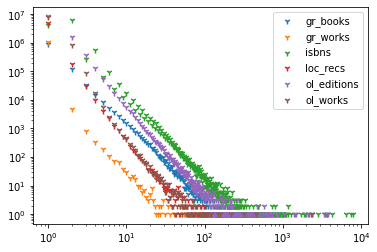

In [7]:
for rt, data in size_dist.groupby('RecType'):
    plt.scatter(data['RecCount'], data['Clusters'], marker='1', label=rt)
plt.legend()
plt.xscale('log')
plt.yscale('log')

Looks mostly fine - we expect a lot of power laws - but the number of clusters with merged GoodReads works is concerning.

## GoodReads Work Merging

Why are GoodReads works merging? Let's look at those.

In [8]:
gr_big = clusters[clusters['gr_works'] > 1].sort_values('gr_works', ascending=False)
gr_big.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6552 entries, 104824844 to 414394334
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   isbns        6552 non-null   int64  
 1   loc_recs     5483 non-null   float64
 2   ol_editions  6407 non-null   float64
 3   ol_works     6407 non-null   float64
 4   gr_books     6552 non-null   float64
 5   gr_works     6552 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 358.3 KB


We have 6K of these clusters. What fraction of the GoodReads-affected clusters is this?

In [9]:
len(gr_big) / clusters['gr_books'].count()

0.005974635156970955

Less than 1%. Not bad, but let's look.

In [10]:
gr_big.head()

,isbns,loc_recs,ol_editions,ol_works,gr_books,gr_works
cluster,,,,,,
104824844,7818,610.0,3432.0,455.0,2266.0,85.0
104887133,3712,408.0,2007.0,322.0,883.0,78.0
105127814,163,4.0,91.0,74.0,60.0,56.0
104983287,327,67.0,269.0,72.0,80.0,54.0
105289159,141,1.0,51.0,18.0,53.0,51.0


What's that big cluster?

In [12]:
biggest = gr_big.index[0]
cluster_titles = pd.read_sql(f'''
    SELECT DISTINCT gr_work_id, work_title
    FROM gr.book_cluster
    JOIN gr.book_ids USING (gr_book_id)
    JOIN gr.work_title USING (gr_work_id)
    WHERE cluster = {biggest} AND work_title IS NOT NULL;
''', db_url())
cluster_titles

,gr_work_id,work_title
0,145554,The Oxford Bookworms Library Stage 1 Best-sell...
1,674438,The Walrus and the Carpenter
2,789261,"Dracula, Longman Annotated Novel (Longman Anno..."
3,798741,Sleeping Beauty
4,879016,"York Notes on ""Dracula"" (York Notes Advanced)"
5,983168,The Complete Cheapskate: How to Get Out of Deb...
6,1112418,Vingt Mille Lieues Sous les Mers
7,1313599,A Little Princess
8,1411202,The Merry Adventures of Robin Hood
9,1483780,The House of the Seven Gables


Let's also find out how many *ratings* are affected by this.

In [13]:
pd.read_sql('''
    SELECT SUM((gr_works > 1)::int), AVG((gr_works > 1)::int)
    FROM gr.add_action
    JOIN gr.cluster_stats ON (book_id = cluster)
''', db_url())

ProgrammingError: (psycopg2.errors.UndefinedTable) relation "gr.add_action" does not exist
LINE 3:     FROM gr.add_action
                 ^

[SQL: 
    SELECT SUM((gr_works > 1)::int), AVG((gr_works > 1)::int)
    FROM gr.add_action
    JOIN gr.cluster_stats ON (book_id = cluster)
]
(Background on this error at: http://sqlalche.me/e/f405)

Almost 9% of our add-to-shelf actions are for such a book - that's disappointing.